<a href="https://www.kaggle.com/mohdnazimislam/using-lstm-and-bilstm?scriptVersionId=86234262" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preprocessed-twitter-tweets/processedNegative.csv
/kaggle/input/preprocessed-twitter-tweets/processedPositive.csv
/kaggle/input/preprocessed-twitter-tweets/processedNeutral.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import string
import nltk
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline
df_positive=pd.read_csv("../input/preprocessed-twitter-tweets/processedNegative.csv",squeeze=True).T.reset_index()
df_neutral=pd.read_csv("../input/preprocessed-twitter-tweets/processedNeutral.csv",squeeze=True).T.reset_index()
df_negative=pd.read_csv("../input/preprocessed-twitter-tweets/processedPositive.csv",squeeze=True).T.reset_index()
df_positive.head()


,index
0,How unhappy some dogs like it though
1,talking to my over driver about where I'm goin...
2,Does anybody know if the Rand's likely to fall...
3,I miss going to gigs in Liverpool unhappy
4,There isnt a new Riverdale tonight ? unhappy


In [3]:
#Adding Sentiments column
df_positive['Sentiments']=1
df_neutral['Sentiments']=0
df_negative['Sentiments']=-1

In [4]:
#merging dataframes
df=pd.concat([df_negative,df_positive,df_neutral],axis=0,ignore_index=True)
df.columns=['Tweets','Sentiments']
df['Sentiments'].value_counts()

 0    1570
-1    1186
 1    1117
Name: Sentiments, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3873 entries, 0 to 3872
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tweets      3873 non-null   object
 1   Sentiments  3873 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 60.6+ KB


In [6]:
#clean data
from  nltk.stem.porter import PorterStemmer
from  nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
ps=PorterStemmer()


def cleanText(text):
  text=re.sub(r'@[A-Za-z0-9]+','',text) # removed @mentions
  text=re.sub(r'#','',text) #removing symbol #
  text=re.sub(r'RT[\s]+','',text) #removing retweets
  text=re.sub(r'https?:\/\/\S+','',text) #removing hyperlinks
  text=re.sub(r'[^A-Za-z\s]','',text) #removing special characters
  text=text.lower()
  text=text.split()
  text=[ps.stem(word) for word in text if not word in stopwords.words('english')]
  text=' '.join(text)
  return text

df['Tweets']=df['Tweets'].apply(cleanText)
df


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Tweets,Sentiments
0,inspir aspect fashion,-1
1,fit,-1
2,beauti person kiss thefashionicon,-1
3,apka apna awam ka channel franklin tv aam admi...,-1
4,beauti album greatest unsung guitar geniu time...,-1
...,...,...
3868,idfc offici vikram limay,0
3869,former captain diana edulji other panel run,0
3870,suprem court name former cag head member panel...,0
3871,court summon cm suspend bjp mp accus crimin de...,0


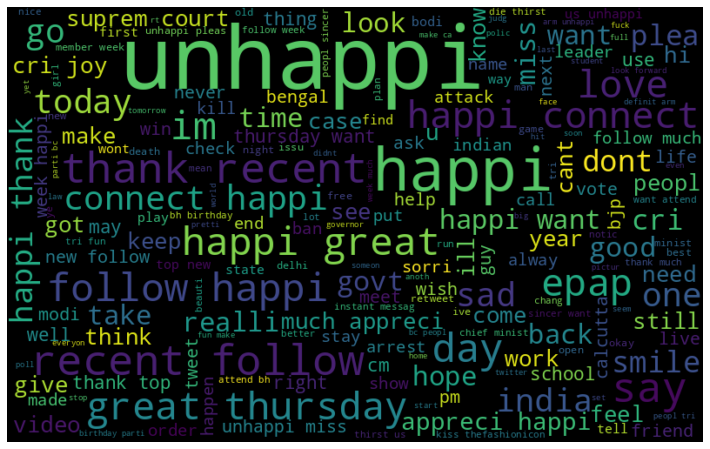

In [7]:
#Visualize

allWords=" ".join([sentence for sentence in df['Tweets']])

from wordcloud import WordCloud
wordcloud=WordCloud(width=800,height=500,random_state=42,max_font_size=100).generate(allWords)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(
    df['Tweets'].values, df['Sentiments'].values, test_size=0.25, random_state=42)

In [9]:
#converting string into integer using Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#instantialing tokenizer
max_vocab=500000
tokenizer=Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)


In [10]:
#vocabulary of dataset
wordidx=tokenizer.word_index
len(wordidx)

4230

In [11]:
#converting sentence to sequence
train_seq=tokenizer.texts_to_sequences(X_train)
test_seq=tokenizer.texts_to_sequences(X_test)
len(train_seq),len(y_train)

(2904, 2904)

In [12]:
#pad sequences to equal length
pad_train=pad_sequences(train_seq)
T=pad_train.shape[1]
pad_train.shape

(2904, 20)

In [13]:
pad_test=pad_sequences(test_seq,maxlen=T)
pad_test.shape

(969, 20)

 #  **Using LSTM**

In [14]:
from tensorflow.keras.layers import Embedding, LSTM, Dense,GlobalMaxPool1D,Input
from tensorflow.keras.models import Model
M=100 # lstm dimension
D=20  #embedding_features
i = Input(shape=(T, ))
x= Embedding(max_vocab+1,D)(i)
x=LSTM(M,return_sequences=True)(x)
x=GlobalMaxPool1D()(x)
x=Dense(32,activation='relu')(x)
x=Dense(1,activation='softmax')(x)

model=Model(i,x)
print(model.summary())
warnings.filterwarnings("ignore")

2022-01-26 16:31:55.911081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 16:31:56.007265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 16:31:56.008028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 16:31:56.009398: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 20)            10000020  
_________________________________________________________________
lstm (LSTM)                  (None, 20, 100)           48400     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                3232      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 10,051,685
Trainable params: 10,051,685
Non-trainable params: 0
_________________________________________________

In [15]:
#model compile
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
r=model.fit(pad_train,y_train,validation_data=(pad_test,y_test),epochs=100,batch_size=64)

Epoch 1/100


2022-01-26 16:31:58.492129: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-26 16:32:00.691582: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


46/46 [==============================] - 4s 20ms/step - loss: 0.0000e+00 - accuracy: 0.2924 - val_loss: 0.0000e+00 - val_accuracy: 0.2766
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.2924 - val_loss: 0.0000e+00 - val_accuracy: 0.2766
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.2924 - val_loss: 0.0000e+00 - val_accuracy: 0.2766
Epoch 4/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.2924 - val_loss: 0.0000e+00 - val_accuracy: 0.2766
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.2924 - val_loss: 0.0000e+00 - val_accuracy: 0.2766
Epoch 6/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.2924 - val_loss: 0.0000e+00 - val_accuracy: 0.2766
Epoch 7/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 0.2924 - val_loss: 0.

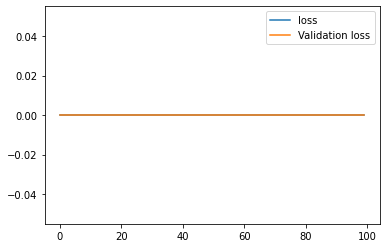

In [16]:
#plotting the loss and val loss
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='Validation loss')
plt.legend()


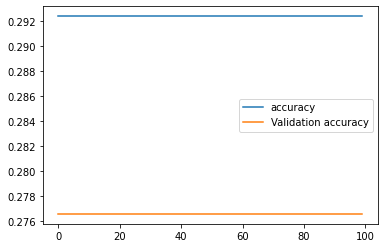

In [17]:
#plotting the accuracy and val accuracy
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='Validation accuracy')
plt.legend()

In [18]:
from tensorflow.keras.layers import Embedding, LSTM, Dense,GlobalMaxPool1D,Input,Bidirectional
from tensorflow.keras.models import Model
M=100 # lstm dimension
D=20  #embedding_features
i = Input(shape=(T, ))
x= Embedding(max_vocab+1,D)(i)
x=Bidirectional(LSTM(M,return_sequences=True))(x)
x=GlobalMaxPool1D()(x)
x=Dense(32,activation='relu')(x)
x=Dense(1,activation='softmax')(x)

model2=Model(i,x)
print(model2.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 20)            10000020  
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 200)           96800     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 10,103,285
Trainable params: 10,103,285
Non-trainable params: 0
_______________________________________________

In [19]:
#model compile
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
r2=model2.fit(pad_train,y_train,validation_data=(pad_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
46/46 [==============================] - 3s 23ms/step - loss: 0.0000e+00 - accuracy: 0.2924 - val_loss: 0.0000e+00 - val_accuracy: 0.2766
Epoch 2/100
46/46 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.2924 - val_loss: 0.0000e+00 - val_accuracy: 0.2766
Epoch 3/100
46/46 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.2924 - val_loss: 0.0000e+00 - val_accuracy: 0.2766
Epoch 4/100
46/46 [==============================] - 1s 14ms/step - loss: 0.0000e+00 - accuracy: 0.2924 - val_loss: 0.0000e+00 - val_accuracy: 0.2766
Epoch 5/100
46/46 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - accuracy: 0.2924 - val_loss: 0.0000e+00 - val_accuracy: 0.2766
Epoch 6/100
46/46 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.2924 - val_loss: 0.0000e+00 - val_accuracy: 0.2766
Epoch 7/100
46/46 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.2

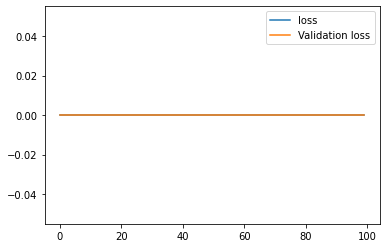

In [20]:
#plotting the loss and val loss
plt.plot(r2.history['loss'],label='loss')
plt.plot(r2.history['val_loss'],label='Validation loss')
plt.legend()

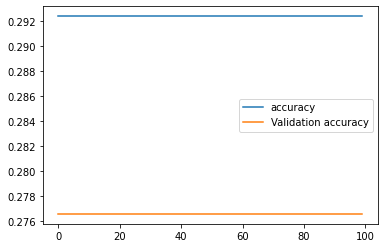

In [21]:
#plotting the accuracy and val accuracy
plt.plot(r2.history['accuracy'],label='accuracy')
plt.plot(r2.history['val_accuracy'],label='Validation accuracy')
plt.legend()